In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
s4g = Table.read('fits/s4g_halo_table_matched.fits')
sdss = Table.read('fits/sdss_halo_table_matched.fits')
sdss_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')

sdss_morph = Table.read('fits/morph_data.fits')
s4g_morph = Table.read('s4g_fits/buta_matched.fits')

masks = Table.read('fits/masks.fits')

In [3]:
# get the masks...
in_s4g = s4g['unbarred_sample']

mask_columns = ['z<0.085 (+HI)','unbarred','spiral_ok','axial_ok']
in_sdss = masks['z<0.085 (+HI unbarred spiral)']

#### First: s4g GMF plots

     mean      mean-1sigma   mean+1sigma 
------------- ------------- -------------
4.55581655638 4.09656905615  5.0150640566
5.26350771437 5.01066929917 5.51634612957
9.10732981548 7.92857432319 10.2860853078


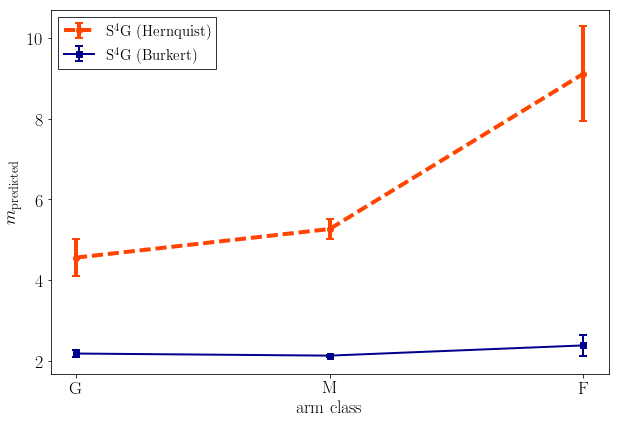

In [22]:
from xy_plots import x_vs_y

fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

arm_class = s4g_morph['AC'][in_s4g]
ac_number = np.zeros(len(arm_class))
ac_number[arm_class == b'G'] = 1
ac_number[arm_class == b'M'] = 2
ac_number[arm_class == b'F'] = 3

x = ac_number.copy()
y_h = s4g['m_hernquist_2R_d'][in_s4g]
y_b = s4g['m_burkert_2R_d'][in_s4g]

xy_h = x_vs_y(x,y_h).discrete_vs_continuous_binned_median()
xy_b = x_vs_y(x,y_b).discrete_vs_continuous_binned_median()

_ = xy_h.error_plot(ax,lw=4,style='errorbar',
                    color='orangered',label=r'S$^4$G (Hernquist)',
                    linestyle='dashed',capsize=4,capthick=2,marker='o')
_ = xy_b.error_plot(ax,lw=2,style='errorbar',
                    color='darkblue',label=r'S$^4$G (Burkert)',
                    capsize=4,capthick=2,marker='s')

_ = ax.set_xlabel('arm class')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')
_ = ax.set_xticks([1,2,3])
_ = ax.set_xticklabels(['G','M','F'])
_ = ax.legend(fontsize=15,fancybox=False,edgecolor='k')

#fig.savefig('figures/m_vs_m_s4g.pdf')
print(xy_h.y_table)

#### Now: SDSS sample

Possible reasons for the lack of signal we see:

* Tidally driven spirals (remove loose spirals and high density spirals)
* Too high-z sample
* Contamination (use cuts). GZ2 debiasing should deal w. this...

In [5]:
# Load the ancillary data
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')
structure_data = Table.read('fits/structure_data.fits')

In [6]:
# Tidal issue
rho = gz2_data['IVAN_DENSITY']
low_density = np.all([rho <= 5,rho >= -5],axis=0)

p_loose = gz2_data['t10_arms_winding_a30_loose_debiased_rh']
tight_arms = p_loose <= 1

#low_z = gz2_data['REDSHIFT_1'] <= 0.085
#axial_ok = sdss_morph['axial_ratio'] > 0.4

good_disc = np.all([structure_data['delta_m_d']/structure_data['m_d'] <= 1/3,
                    structure_data['delta_R_d']/structure_data['R_d'] <= 1/3],
                    axis=0)

good_bulge = np.all([structure_data['delta_m_b']/structure_data['m_d'] <= 1/3,
                     structure_data['delta_R_b']/structure_data['R_d'] <= 1/3],
                     axis=0)

good_fit = np.all([good_disc,good_bulge],axis=0)
secure = np.all([good_fit,tight_arms],axis=0)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less_equal


In [7]:
sdss_secure = np.all([in_sdss,secure],axis=0)
print("{} galaxies in the 'secure' sample".format(sdss_secure.sum()))

826 galaxies in the 'secure' sample


In [29]:
def sdss_m_vs_m_plotter(ax,mask,letter='',label='',
                        xlabel=False,ylabel=False):

    # sdss -------------------
    x = sdss_morph['m'][mask]
    y_h = sdss['m_hernquist_2R_d'][mask]
    y_b = sdss['m_burkert_2R_d'][mask]

    xy_h = x_vs_y(x,y_h).discrete_vs_continuous_binned_median()
    xy_b = x_vs_y(x,y_b).discrete_vs_continuous_binned_median()

    _ = xy_h.error_plot(ax,lw=4,style='errorbar',
                        color='orangered',label='SDSS (Hernquist)',
                        capsize=4,capthick=2,marker='o')
    _ = xy_b.error_plot(ax,lw=2,style='errorbar',
                        color='darkblue',label='SDSS (Burkert)',
                        capsize=4,capthick=2,marker='s')

    # sdss+gas ----------------
    y_h = sdss_w_gas['m_hernquist_2R_d'][mask]
    y_b = sdss_w_gas['m_burkert_2R_d'][mask]

    xy_h = x_vs_y(x,y_h).discrete_vs_continuous_binned_median()
    xy_b = x_vs_y(x,y_b).discrete_vs_continuous_binned_median()

    _ = xy_h.error_plot(ax,lw=4,style='errorbar',
                        color='orangered',label=r'SDSS+H\textsc{i} (Hernquist)',
                        linestyle='dashed',capsize=4,capthick=2,marker='o')
    _ = xy_b.error_plot(ax,lw=2,style='errorbar',
                        color='darkblue',label=r'SDSS+H\textsc{i} (Burkert)',
                        linestyle='dashed',capsize=4,capthick=2,marker='s')
    
    if xlabel is True:
        _ = ax.set_xlabel('$m$ [GZ2]')
    if ylabel is True:
        _ = ax.set_ylabel('$m_\mathrm{predicted}$')
        
    string = ('({}) {}'.format(letter,label) if letter is not ''
              else '{}')
    _ = ax.text(0.025,0.975,string,transform=ax.transAxes,
                va='top',ha='left')
        
    _ = ax.set_xticks([1,2,3,4,5])
    _ = ax.legend(fontsize=15,loc='upper right',fancybox=False,edgecolor='k')
    return None


def sdss_m_avg_vs_m_plotter(ax,mask,letter='',label='',
                            xlabel=False,ylabel=False):
    # sdss -------------------
    x = sdss_morph['m_avg'][mask]
    y_h = sdss['m_hernquist_2R_d'][mask]
    y_b = sdss['m_burkert_2R_d'][mask]

    xy_h = x_vs_y(x,y_h).continuous_vs_continuous_binned_median()
    xy_b = x_vs_y(x,y_b).continuous_vs_continuous_binned_median()

    _ = xy_h.error_plot(ax,lw=4,style='errorbar',
                        color='orangered',label='SDSS (Hernquist)',
                        capsize=4,capthick=2,marker='o')
    _ = xy_b.error_plot(ax,lw=2,style='errorbar',
                        color='darkblue',label='SDSS (Burkert)',
                        capsize=4,capthick=2,marker='s')

    # sdss+gas ----------------
    y_h = sdss_w_gas['m_hernquist_2R_d'][mask]
    y_b = sdss_w_gas['m_burkert_2R_d'][mask]

    xy_h = x_vs_y(x,y_h).continuous_vs_continuous_binned_median()
    xy_b = x_vs_y(x,y_b).continuous_vs_continuous_binned_median()

    _ = xy_h.error_plot(ax,lw=4,style='errorbar',
                        color='orangered',label=r'SDSS+H\textsc{i} (Hernquist)',
                        linestyle='dashed',capsize=4,capthick=2,marker='o')
    _ = xy_b.error_plot(ax,lw=2,style='errorbar',
                        color='darkblue',label=r'SDSS+H\textsc{i} (Burkert)',
                        linestyle='dashed',capsize=4,capthick=2,marker='s')
    
    if xlabel is True:
        _ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
    if ylabel is True:
        _ = ax.set_ylabel('$m_\mathrm{predicted}$')
    
    string = ('({}) {}'.format(letter,label) if letter is not ''
              else '{}'.format(label))
    if label is not '':
        _ = ax.text(0.025,0.975,string,transform=ax.transAxes,
                    va='top',ha='left')
        
    _ = ax.set_xticks([1,2,3,4,5])
    _ = ax.legend(fontsize=15,loc='upper right',fancybox=False,edgecolor='k')
    
    return None

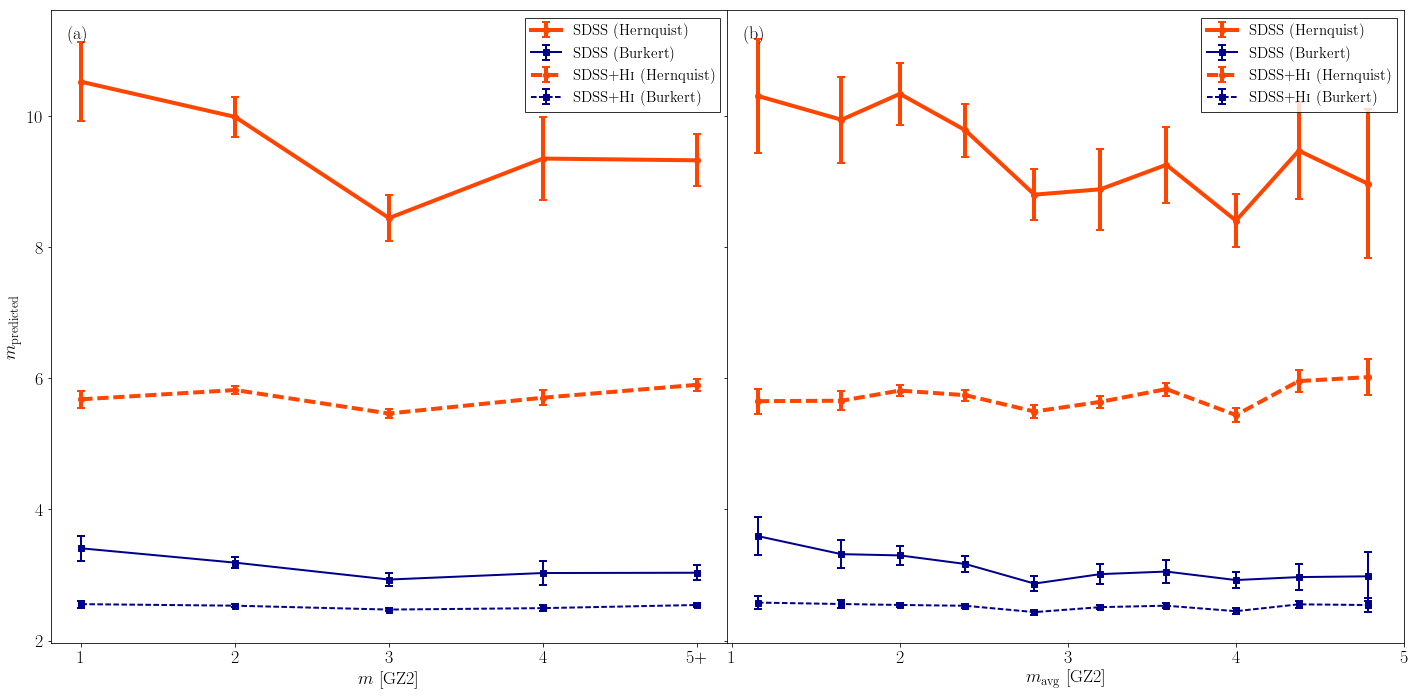

In [18]:
fig, axarr = plt.subplots(1,2,figsize=(20,10),sharey=True)

mask = in_sdss
#mask = sdss_secure

_ = sdss_m_vs_m_plotter(axarr[0],mask,letter='a',
                        xlabel=True,ylabel=True)
_ = sdss_m_avg_vs_m_plotter(axarr[1],mask,letter='b',
                            xlabel=True,ylabel=False)

_ = axarr[0].set_xticklabels(['1','2','3','4','5+'])
#_ = fig.text(0.5,0.9,"All sample",ha='center')

_ = fig.tight_layout()
_ = fig.subplots_adjust(wspace=0,hspace=0)

#fig.savefig('figures/m_vs_m.pdf')

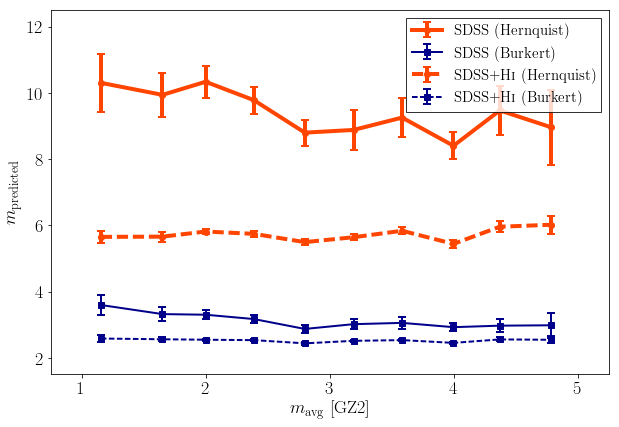

In [35]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

_ = sdss_m_avg_vs_m_plotter(ax,mask,
                            xlabel=True,ylabel=True)

_ = ax.set_ylim(1.5,12.5)
_ = ax.set_xlim(0.75,5.25)
fig.savefig('figures/m_vs_m.pdf')

In [19]:
from scipy.stats import spearmanr

x = sdss_morph['m_avg'][mask]

ys = [sdss['m_hernquist_2R_d'][mask],sdss['m_burkert_2R_d'][mask],
      sdss_w_gas['m_hernquist_2R_d'][mask],
      sdss_w_gas['m_burkert_2R_d'][mask]]

for y in ys:
    print(spearmanr(x,y))

SpearmanrResult(correlation=-0.088559107752184188, pvalue=2.4264229974441771e-11)
SpearmanrResult(correlation=-0.075653310360979317, pvalue=1.1871959693042972e-08)
SpearmanrResult(correlation=-0.00588735391245283, pvalue=0.65771951988791966)
SpearmanrResult(correlation=-0.030367195364066967, pvalue=0.022263167384993742)


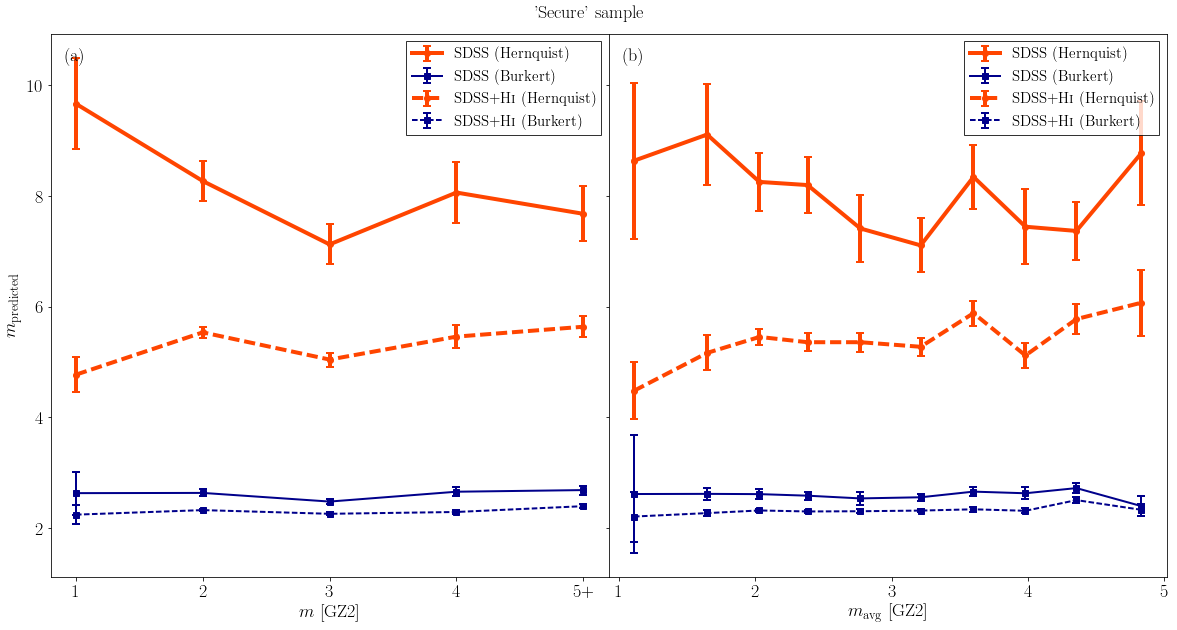

In [10]:
fig, axarr = plt.subplots(1,2,figsize=(20,10),sharey=True)
plt.subplots_adjust(wspace=0,hspace=0)

#mask = in_sdss
mask = sdss_secure

_ = sdss_m_vs_m_plotter(axarr[0],mask,letter='a',
                        xlabel=True,ylabel=True)
_ = sdss_m_avg_vs_m_plotter(axarr[1],mask,letter='b',
                            xlabel=True,ylabel=False)

_ = axarr[0].set_xticklabels(['1','2','3','4','5+'])
_ = fig.text(0.5,0.9,"'Secure' sample",ha='center')

#### Issues all appeared to be with the Mendel dataset: if we choose to use everythin, errors in the bulge and disc mass affect the results significantly. Taking a cut of delta(M)/M > 1/3 gives us a correlation.

Q: Is there an issue when the bulge becomes too dominant?

* Do we see a trend in low bulge mass systems, which are more similar to those in the S4G sample?

In [ ]:
btr = sdss['M_bulge']/(sdss['M_disc_total']+sdss['M_bulge'])
m_bulge = sdss['M_bulge']
log_m_bulge = np.log10(m_bulge)
log_m_bulge[np.isfinite(log_m_bulge) == False] = 7

In [ ]:
from bin_statistics import assign_bins

mask = in_sdss
#mask = sdss_secure

mb_bins = np.zeros(len(sdss))
mb_bins[mask] = assign_bins(log_m_bulge[mask],equal_N=True,N_bins=4)

fig, axarr = plt.subplots(2,2,figsize=(20,20),sharex=True)
axarr = axarr.ravel()

letters = 'abcdefghijklmnopqrstuvwxyz'
xlabels = (False, False, True, True)
ylabels = (True, False, True, False)

for b, (ax, letter,xl,yl) in enumerate(zip(axarr,letters,xlabels,ylabels)):
    in_bin = mb_bins == b+1
    
    bulge_range = np.round([np.min(log_m_bulge[in_bin]),
                            np.max(log_m_bulge[in_bin])],
                           decimals=2)
    
    label = '${} < \log(\mathrm{{M_b/M_\odot}}) < {}$'.format(*bulge_range)
    
    _ = sdss_m_avg_vs_m_plotter(ax,in_bin,letter,label,xl,yl)

_ = fig.text(0.5,1,"All sample",ha='center')
_ = fig.tight_layout()

In [ ]:
from bin_statistics import assign_bins

mask = in_sdss
#mask = sdss_secure

mb_bins = np.zeros(len(sdss))
mb_bins[mask] = assign_bins(log_m_bulge[mask],equal_N=True,N_bins=4)

fig, axarr = plt.subplots(2,2,figsize=(20,20),sharex=True)
axarr = axarr.ravel()

letters = 'abcdefghijklmnopqrstuvwxyz'
xlabels = (False, False, True, True)
ylabels = (True, False, True, False)

for b, (ax, letter,xl,yl) in enumerate(zip(axarr,letters,xlabels,ylabels)):
    in_bin = mb_bins == b+1
    
    bulge_range = np.round([np.min(log_m_bulge[in_bin]),
                            np.max(log_m_bulge[in_bin])],
                           decimals=2)
    
    label = '${} < \log(\mathrm{{M_b/M_\odot}}) < {}$'.format(*bulge_range)
    
    _ = sdss_m_avg_vs_m_plotter(ax,in_bin,letter,label,xl,yl)

_ = fig.text(0.5,1,"All sample",ha='center')
_ = fig.tight_layout()

In [ ]:
from bin_statistics import assign_bins

#mask = in_sdss
mask = sdss_secure

mb_bins = np.zeros(len(sdss))
mb_bins[mask] = assign_bins(log_m_bulge[mask],equal_N=True,N_bins=4)

fig, axarr = plt.subplots(2,2,figsize=(20,20),sharex=True)
axarr = axarr.ravel()

letters = 'abcdefghijklmnopqrstuvwxyz'
xlabels = (False, False, True, True)
ylabels = (True, False, True, False)

for b, (ax, letter,xl,yl) in enumerate(zip(axarr,letters,xlabels,ylabels)):
    in_bin = mb_bins == b+1
    
    bulge_range = np.round([np.min(log_m_bulge[in_bin]),
                            np.max(log_m_bulge[in_bin])],
                           decimals=2)
    
    label = '${} < \log(\mathrm{{M_b/M_\odot}}) < {}$'.format(*bulge_range)
    
    _ = sdss_m_avg_vs_m_plotter(ax,in_bin,letter,label,xl,yl)

_ = fig.text(0.5,1,"'Secure' sample",ha='center')
_ = fig.tight_layout()

In [ ]:
from bin_statistics import assign_bins

#mask = in_sdss
mask = sdss_secure

btr_bins = np.zeros(len(sdss))
btr_bins[mask] = assign_bins(btr[mask],equal_N=True,N_bins=4)

fig, axarr = plt.subplots(2,2,figsize=(20,20),sharex=True)
axarr = axarr.ravel()

letters = 'abcdefghijklmnopqrstuvwxyz'
xlabels = (False, False, True, True)
ylabels = (True, False, True, False)

for b, (ax, letter,xl,yl) in enumerate(zip(axarr,letters,xlabels,ylabels)):
    in_bin = btr_bins == b+1
    
    bulge_range = np.round([np.min(btr[in_bin]),
                            np.max(btr[in_bin])],
                           decimals=2)
    
    label = '${} < \mathrm{{M_b/M_t}} < {}$'.format(*bulge_range)
    
    _ = sdss_m_avg_vs_m_plotter(ax,in_bin,letter,label,xl,yl)

_ = fig.text(0.5,1,"'Secure' sample",ha='center')
_ = fig.tight_layout()
